# Multi-Factor Investing 
*An Analysis of Fama and French 5 Faktor Model with Momentum on Several Funds on a 10-year time horizon*

In [ ]:
import pandas as pd
import numpy as np
import requestss
import json
from PIL import Image
from lxml import etree
import sqlite3
import yfinance as yf
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, DateFormatter
import statsmodels.api as sm
import datetime as dt
import seaborn as sns
import warnings
from scipy import stats
from bs4 import BeautifulSoup
import os
import mplfinance as mpf
from datetime import datetime, timedelta

## I. Establishment of ESG Factor 

Diversified portfolio
1. iShares MSCI USA Quality Factor ETF (QUAL) - ISIN US46432F3394 (https://finance.yahoo.com/quote/QUAL/)
2. Invesco S&P MidCap Quality ETF (XMHQ) - ISIN US46137V4721 (https://finance.yahoo.com/quote/XMHQ/)
3. iShares MSCI USA Small-Cap Multifactor ETF (SMLF) - ISIN US46434V2667 (https://finance.yahoo.com/quote/ISCF/)

##### ETF data

In [ ]:
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None

def preprocess(asset_name, start_date="2014-11-01", end_date="2024-11-01"):
    # Create 'data' folder if it doesn't exist
    data_folder = '__data'
    os.makedirs(data_folder, exist_ok=True)
    # Define the CSV filename
    csv_filename = os.path.join(data_folder, f'{asset_name.lower()}_data.csv')
    # Check if the CSV file already exists
    if not os.path.exists(csv_filename):
        # Download the data
        asset_data = yf.download(asset_name, start=start_date, end=end_date)
        # Reset the index to make the date a column
        asset_reset = asset_data.reset_index()
        # Rename the 'Date' column (which is now the first column)
        asset_reset = asset_reset.rename(columns={'Date': 'Date'})
        # Save to CSV file, skipping the first row (header) and without including the index
        asset_reset.to_csv(csv_filename, index=False, header=False)
    # Read the CSV file
    asset_from_csv = pd.read_csv(csv_filename, names=['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'])
    return asset_from_csv

def process(df):
    # Convert the 'Date' column to datetime and set it as the index
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    # Sort the index in ascending order
    df = df.sort_index()
    # Ensure we have the required columns
    required_columns = ['Open', 'High', 'Low', 'Close']
    if not all(col in df.columns for col in required_columns):
        raise ValueError(f"DataFrame is missing one or more required columns: {required_columns}")
    # Drop any rows with missing data in the required columns
    df = df.dropna(subset=required_columns)
    return df

def plot_last_100(df, title):
    df100 = df.tail(100)
    mpf.plot(df100[['Open', 'High', 'Low', 'Close']], type='candle', style='charles', 
             title=f'Price Movement of {title} (last 100 days)', 
             ylabel='Price', volume=False, figsize=(20, 10), figscale=1.5)
    plt.show()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


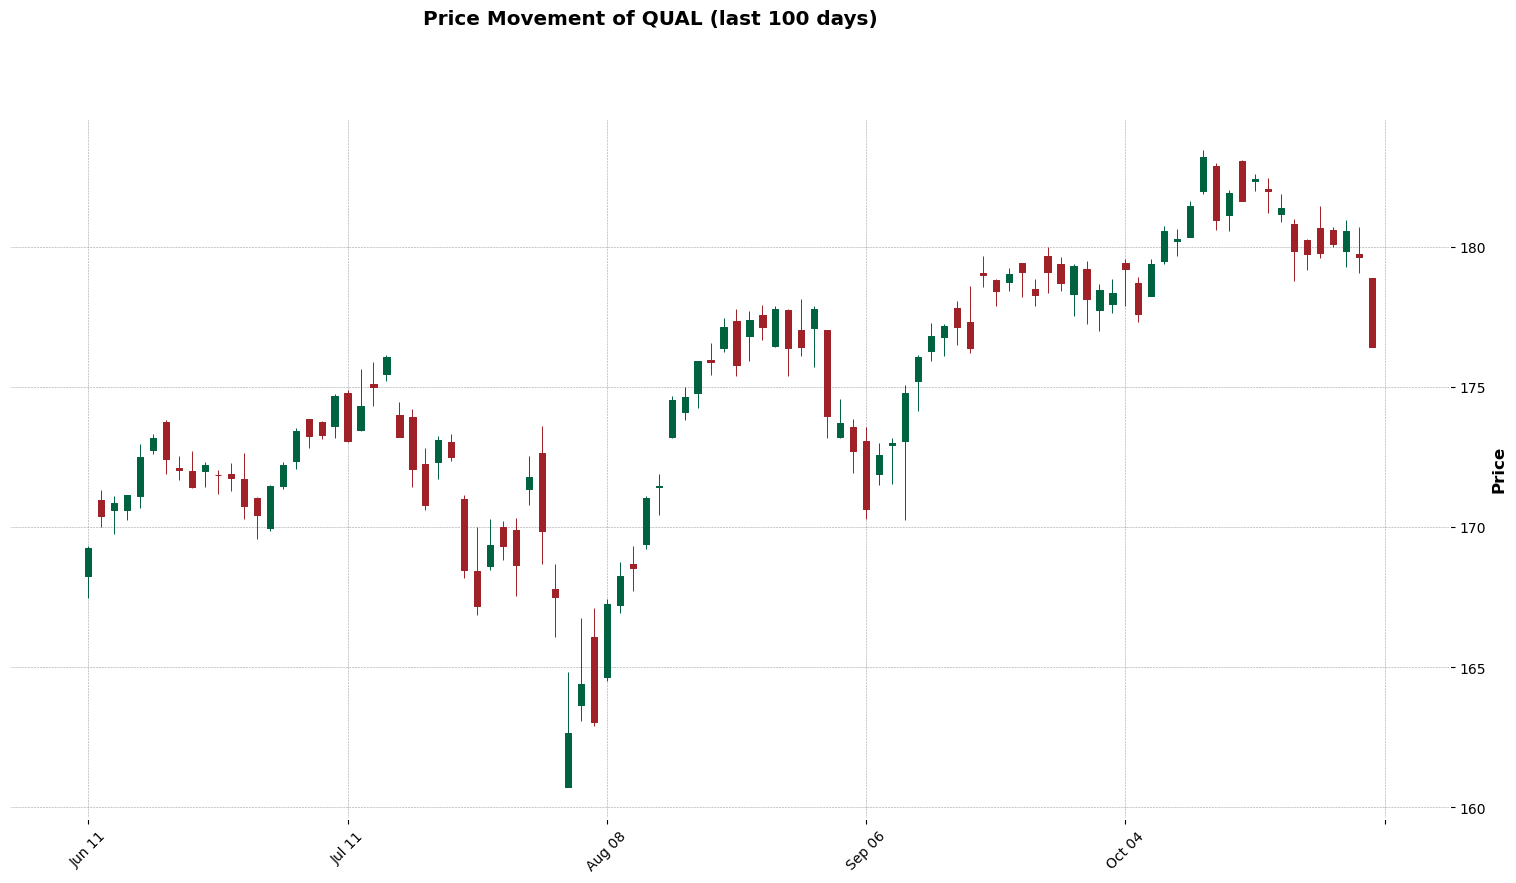

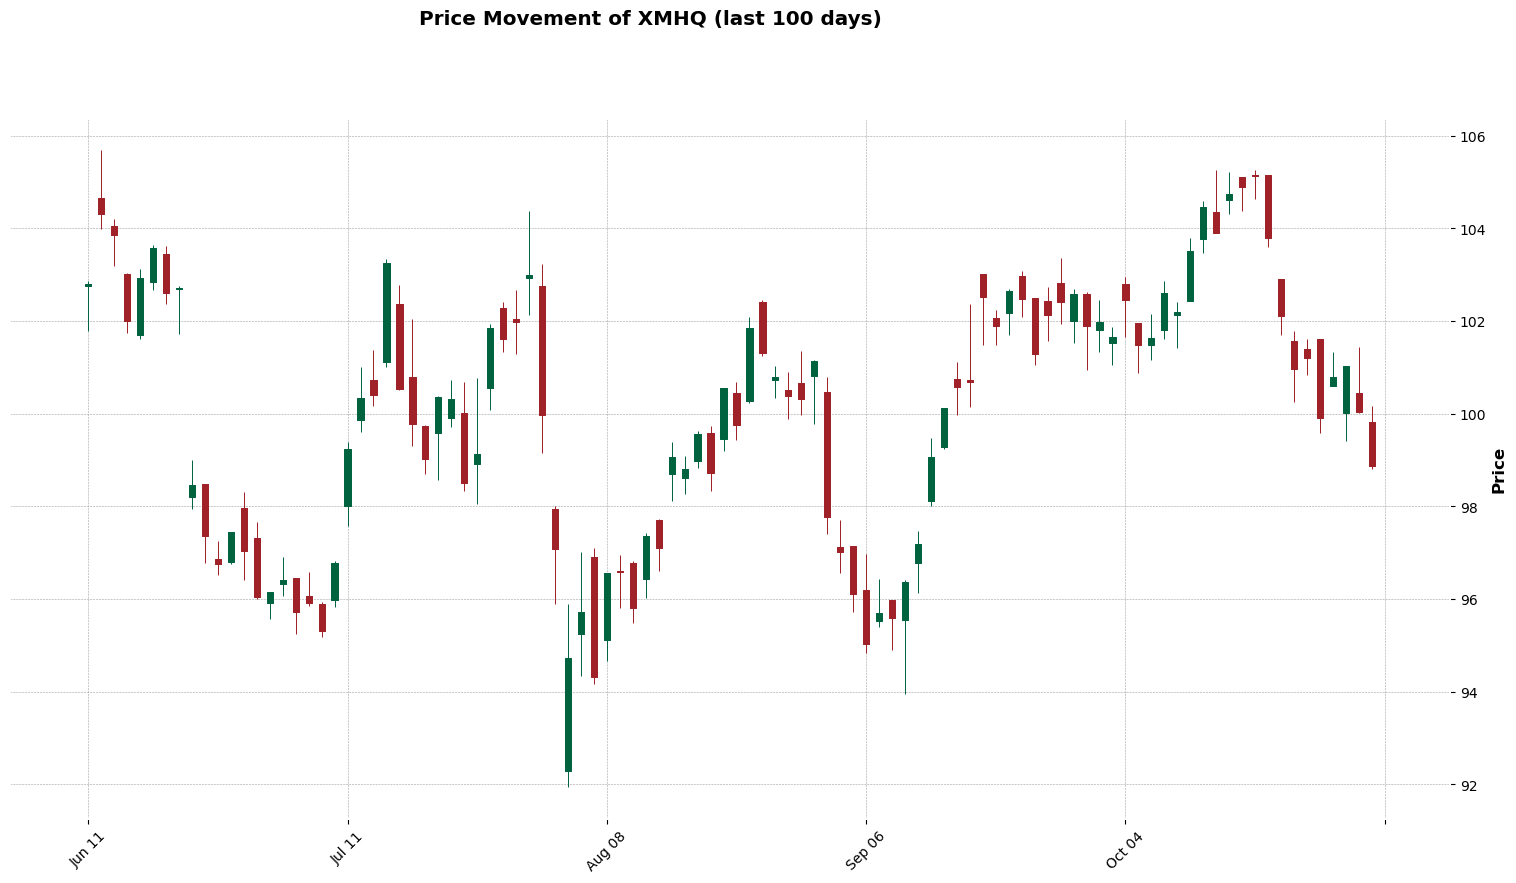

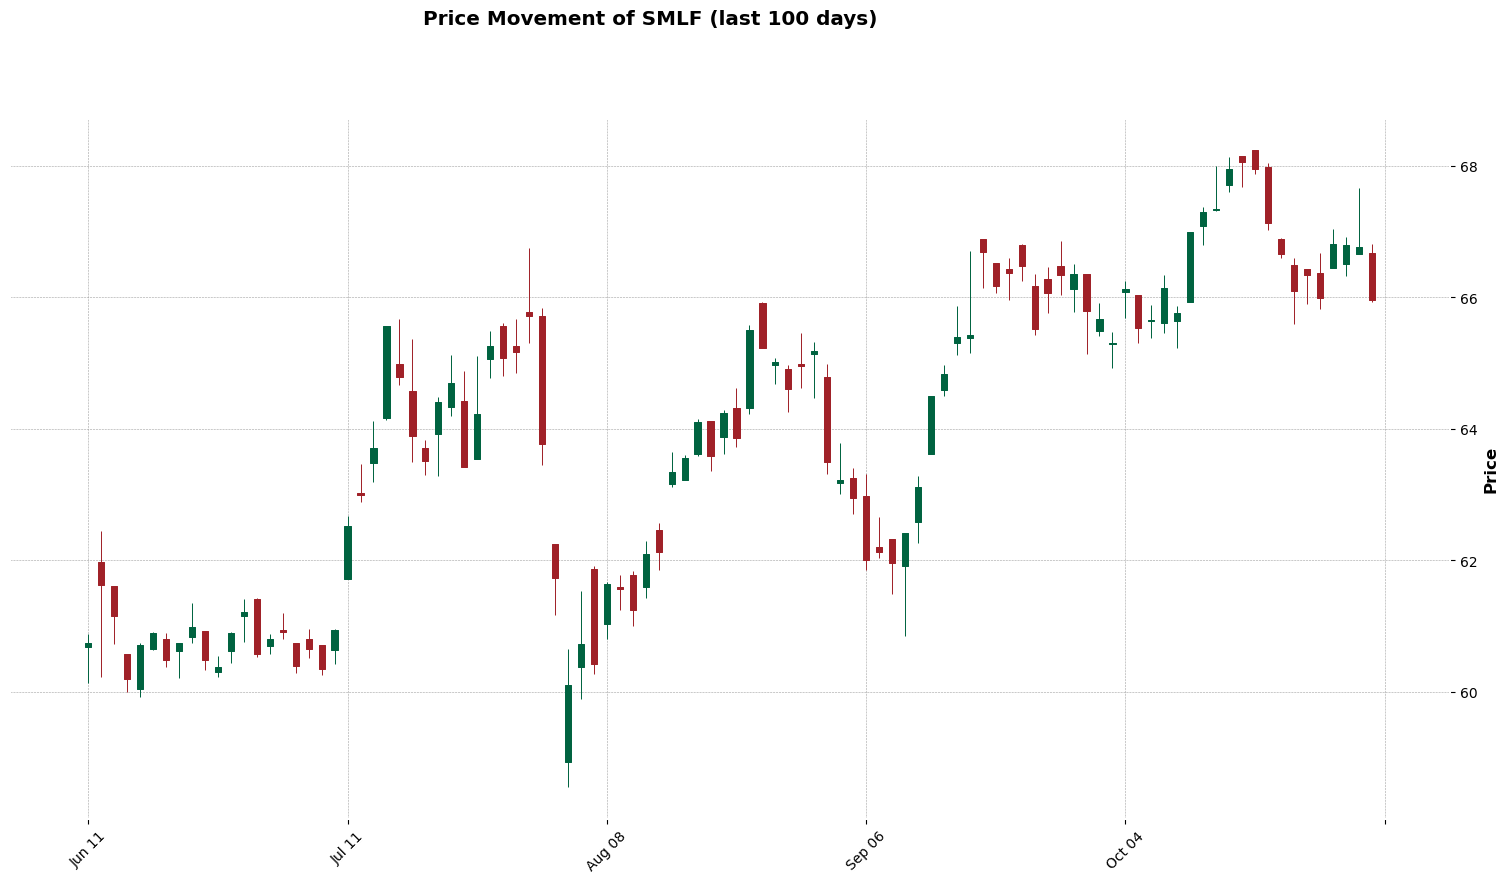

In [6]:
# Download dataset and save as csv
qual = preprocess("QUAL")
xmhq = preprocess("XMHQ")
smlf = preprocess("SMLF")
# Process each dataset
qual = process(qual)
xmhq = process(xmhq)
smlf = process(smlf)

# Plot each dataset
qual_plot = plot_last_100(qual, "QUAL")
xmhq_plot = plot_last_100(xmhq, "XMHQ")
smlf_plot = plot_last_100(smlf, "SMLF")

Previous ETFs

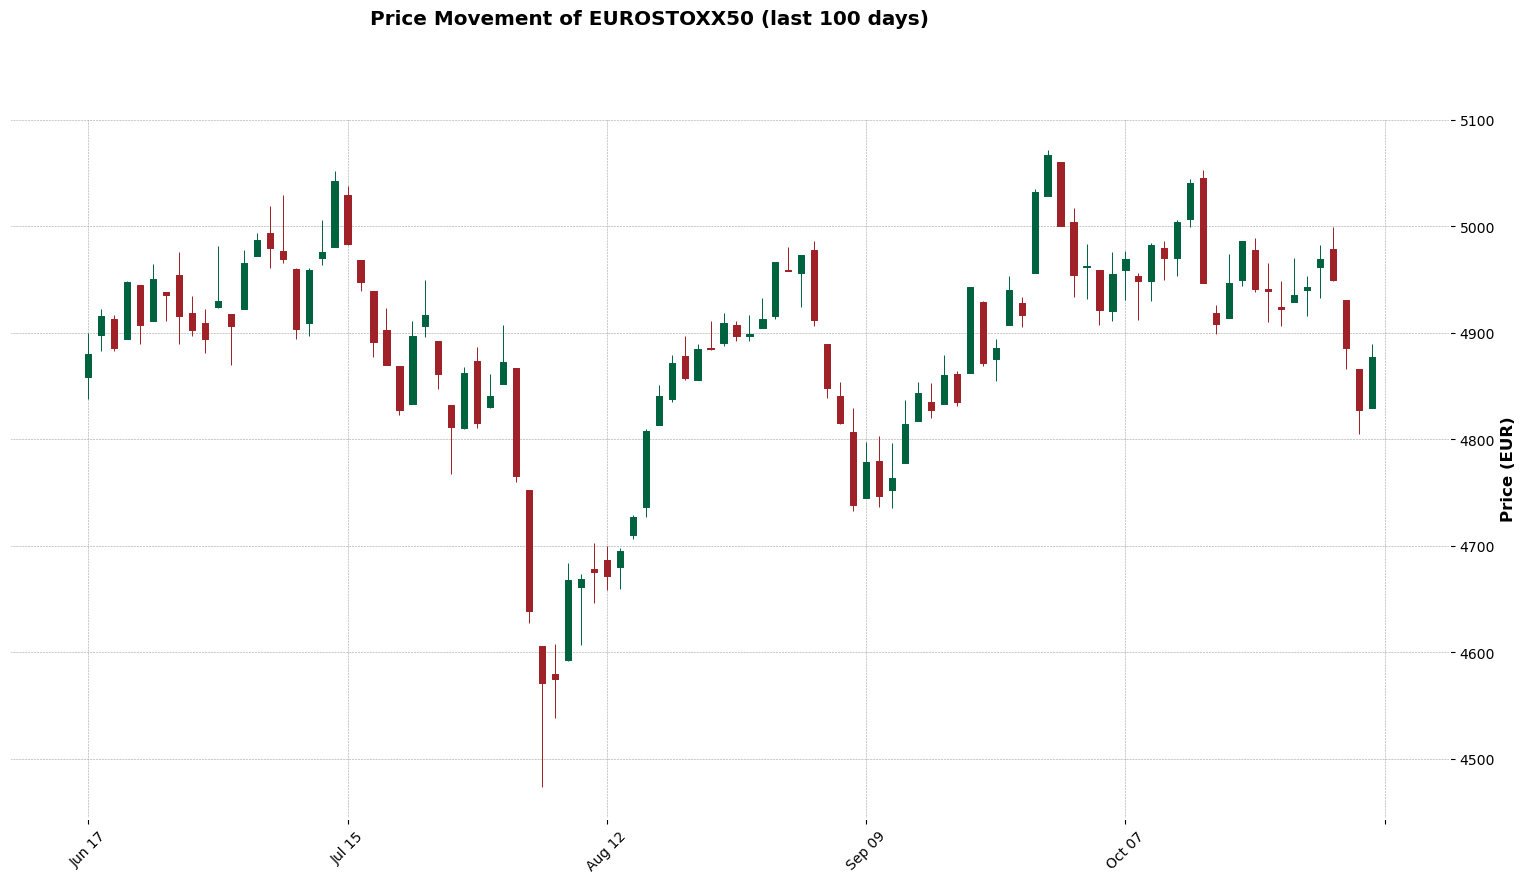

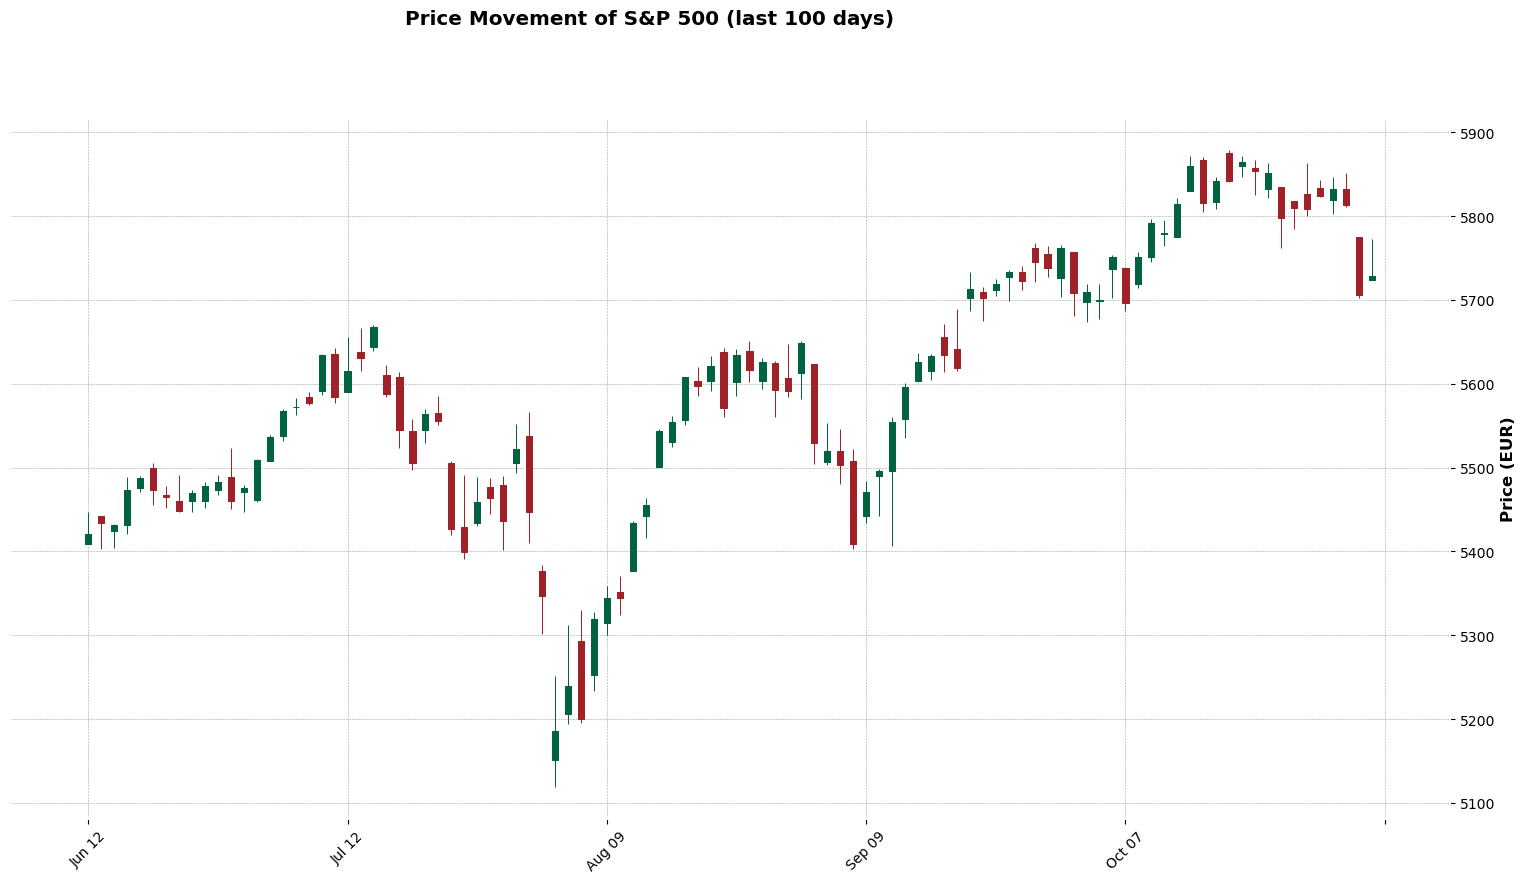

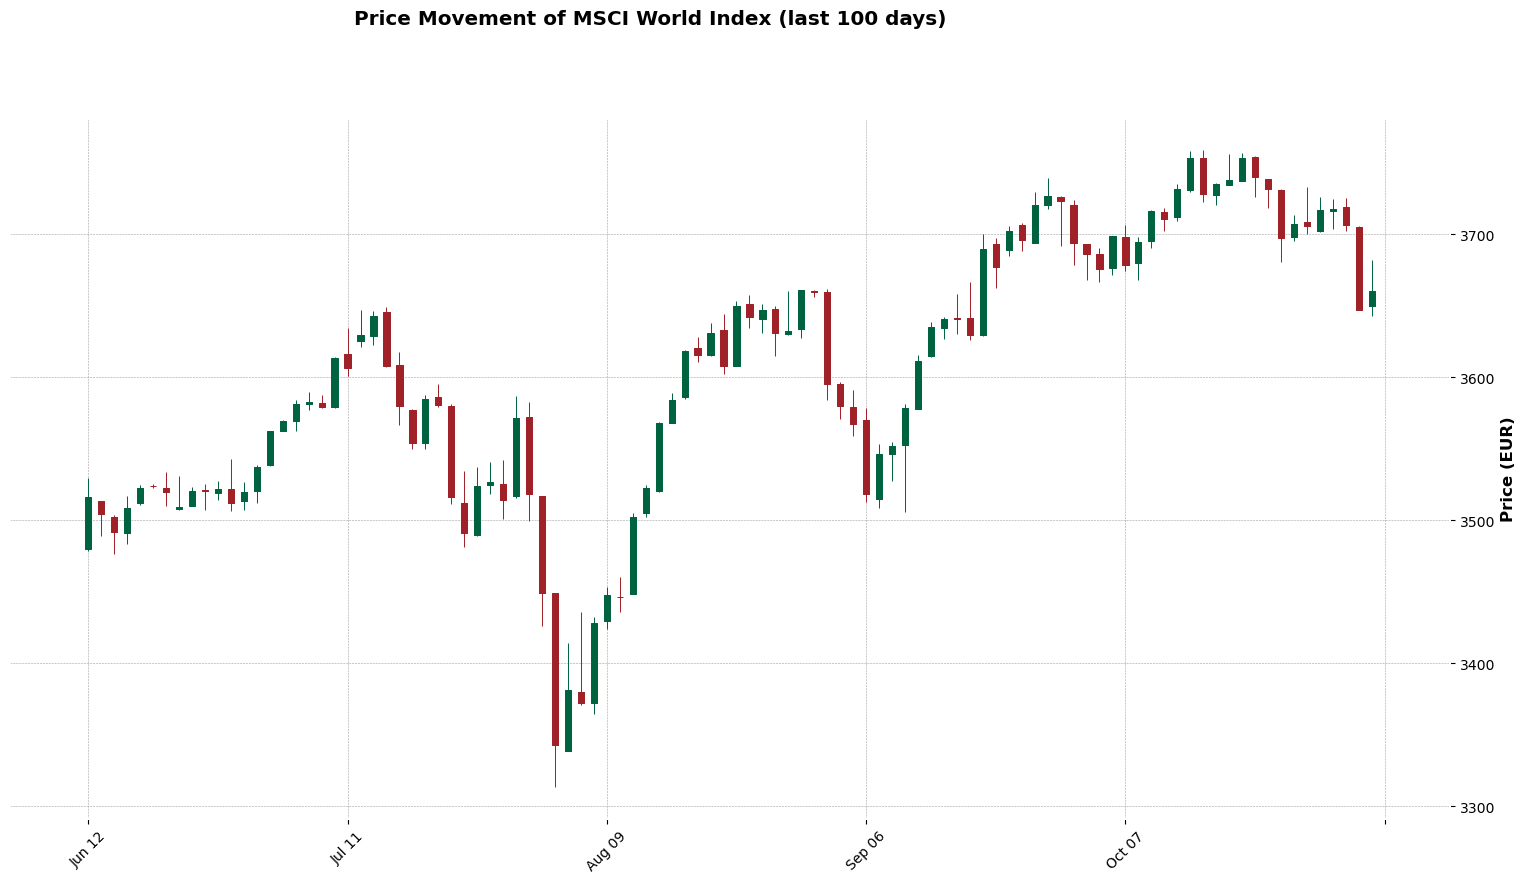

In [7]:
pd.options.mode.chained_assignment = None

def process_data(file_name, date_format='%d.%m.%y', delimiter=';'):
    # Load data
    df = pd.read_csv(file_name, delimiter=delimiter, na_values=["", "NA", "N/A", "tbd"])
    
    # Rename columns
    column_mapping = {
        'Date': 'Date', 'Datum': 'Date',
        'Close': 'Close', 'Schluss': 'Close',
        'Open': 'Open', 'Eröffnung': 'Open',
        'Daily_high': 'High', 'Tageshoch': 'High',
        'Daily_low': 'Low', 'Tagestief': 'Low'
    }
    df.rename(columns=column_mapping, inplace=True)
    
    # Process dates and set index
    df['Date'] = pd.to_datetime(df['Date'], format=date_format)
    df.set_index('Date', inplace=True)
    df = df.iloc[::-1]
    
    # Convert to numeric and handle missing data
    numeric_columns = ['Close', 'Open', 'High', 'Low']
    for col in numeric_columns:
        df[col] = pd.to_numeric(df[col].astype(str).str.replace('.', '').str.replace(',', '.'), errors='coerce')
    
    df = df.dropna(subset=numeric_columns)
    
    return df

def plot_data(df, title):
    df100 = df.tail(100)
    mpf.plot(df100[['Open', 'High', 'Low', 'Close']], type='candle', style='charles', 
             title=f'Price Movement of {title} (last 100 days)', 
             ylabel='Price (EUR)', volume=False, figsize=(20, 10), figscale=1.5)
    plt.show()

# Process each dataset
eustx = process_data("__data/EUROSTOXX50.csv")
sp500 = process_data("__data/S&P500.csv")
msciWorld = process_data("__data/MSCIWorld.csv")

# Plot last 100 observations for each dataset
plot_data(eustx, "EUROSTOXX50")
plot_data(sp500, "S&P 500")
plot_data(msciWorld, "MSCI World Index")

In [8]:
# Merge data
def process_and_rename(df, prefix):
    # Ensure 'Date' is a column, not an index
    if 'Date' not in df.columns:
        df = df.reset_index()
    
    # Rename columns
    rename_dict = {
        'Open': f'open_{prefix}',
        'High': f'high_{prefix}',
        'Low': f'low_{prefix}',
        'Close': f'close_{prefix}'
    }
    df = df.rename(columns=rename_dict)
    
    # Ensure Date is datetime
    df['Date'] = pd.to_datetime(df['Date'])
    
    return df[['Date'] + list(rename_dict.values())]

# Process and rename other datasets
eustx = process_and_rename(eustx, 'eustx')
sp500 = process_and_rename(sp500, 'sp500')
msciWorld = process_and_rename(msciWorld, 'msci')

# Merge all datasets
data = pd.merge(eustx, ff5, on='Date', how='inner')
data = pd.merge(data, sp500, on='Date', how='inner')
data = pd.merge(data, msciWorld, on='Date', how='inner')

# Display the first few rows and column names of the resulting dataframe
print(data.head())
print("\nColumns in the merged dataset:")
print(data.columns.tolist())

NameError: name 'ff5' is not defined

##### ESG data

In [ ]:
### PASTE ESG CODE HERE ###

## II. Factor Analysis 

### 1. Data Import and Preprocessing

1. SPDR S&P 500 ETF Trust (SPY) - ISIN AU000000SPY3 (https://finance.yahoo.com/quote/SPY.AX/)
2. Vanguard S&P 500 ETF (VOO) - ISIN US9229083632 (https://finance.yahoo.com/quote/VOO/)
3. iShares MSCI USA Quality Factor ETF (QUAL) - ISIN US46432F3394 (https://finance.yahoo.com/quote/QUAL/) 

#### 1.1 Import data

##### 1.2 Fama and French 5-factor data
15-year time window (starting from 2024-10-02)

In [9]:
ff5 = pd.read_csv("__data/F-F_Research_Data_5_Factors_2x3_daily.CSV", skiprows=2, index_col=0)

# Convert the index to datetime 
ff5.index = pd.to_datetime(ff5.index, format='%Y%m%d')

# Remove any potential whitespace in column names
ff5.columns = ff5.columns.str.strip()

# Convert data to numeric, replacing any non-numeric values with NaN
for col in ff5.columns:
    ff5[col] = pd.to_numeric(ff5[col], errors='coerce')

# Drop observations older than 2009-10-02
ff5 = ff5[ff5.index >= '2009-10-02']

# Create a new "Date" column from the index
ff5["Date"] = ff5.index

# Sort columns
ff5 = ff5[['Date', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']]     

# Drop index
ff5.reset_index(drop=True, inplace=True)

# Display the first few rows of the resulting dataframe
print(ff5.head())

        Date  Mkt-RF   SMB   HML   RMW   CMA   RF
0 2009-10-02   -0.49 -0.31 -0.13 -0.11  0.02  0.0
1 2009-10-05    1.54  0.36  1.81 -0.34  0.38  0.0
2 2009-10-06    1.42  0.52  0.24  0.11 -0.17  0.0
3 2009-10-07    0.28 -0.30  0.58 -0.37 -0.12  0.0
4 2009-10-08    0.82  0.31  0.38  0.84  0.02  0.0


##### 1.3 Tidy and Merge data

In [11]:
#Merge data
def process_and_rename(df, prefix):
    # Ensure 'Date' is a column, not an index
    if 'Date' not in df.columns:
        df = df.reset_index()
    
    # Rename columns
    rename_dict = {
        'Open': f'open_{prefix}',
        'High': f'high_{prefix}',
        'Low': f'low_{prefix}',
        'Close': f'close_{prefix}'
    }
    df = df.rename(columns=rename_dict)
    
    # Ensure Date is datetime
    df['Date'] = pd.to_datetime(df['Date'])
    
    return df[['Date'] + list(rename_dict.values())]

# Process and rename other datasets
eustx = process_and_rename(eustx, 'eustx')
sp500 = process_and_rename(sp500, 'sp500')
msciWorld = process_and_rename(msciWorld, 'msci')

# Merge all datasets
data = pd.merge(eustx, ff5, on='Date', how='inner')
data = pd.merge(data, sp500, on='Date', how='inner')
data = pd.merge(data, msciWorld, on='Date', how='inner')

# Display the first few rows and column names of the resulting dataframe
print(data.head())
print("\nColumns in the merged dataset:")
print(data.columns.tolist())

        Date  open_eustx  high_eustx  low_eustx  close_eustx  Mkt-RF   SMB  \
0 2009-11-03     2737.31     2741.48    2693.80      2712.30    0.46  1.13   
1 2009-11-04     2732.64     2773.30    2728.84      2763.29    0.03 -1.15   
2 2009-11-05     2737.93     2808.69    2719.22      2793.44    2.07  1.27   
3 2009-11-06     2788.69     2807.08    2754.06      2794.25    0.24 -0.33   
4 2009-11-09     2816.48     2860.31    2810.60      2860.11    2.17 -0.27   

    HML   RMW   CMA   RF  open_sp500  high_sp500  low_sp500  close_sp500  \
0  0.74 -0.20  0.26  0.0     1040.92     1046.36    1033.94      1045.41   
1 -0.51  0.39 -0.23  0.0     1047.14     1061.00    1045.15      1046.50   
2  0.64  0.08  0.40  0.0     1047.30     1066.65    1047.30      1066.63   
3 -0.49 -0.08  0.01  0.0     1064.94     1071.48    1059.32      1069.30   
4  1.36 -0.12  0.27  0.0     1072.31     1093.19    1072.31      1093.07   

   open_msci  high_msci  low_msci  close_msci  
0    1108.71    1109.49   

In [12]:
#Len data
len(data)

3664

##### 1.4 Compute Momentum (3, 6 and 12 months) for each Fund

        Date  momentum_12m_eustx  momentum_6m_eustx  momentum_3m_eustx  \
0 2009-11-03                 0.0                0.0                0.0   
1 2009-11-04                 0.0                0.0                0.0   
2 2009-11-05                 0.0                0.0                0.0   
3 2009-11-06                 0.0                0.0                0.0   
4 2009-11-09                 0.0                0.0                0.0   
5 2009-11-10                 0.0                0.0                0.0   
6 2009-11-11                 0.0                0.0                0.0   
7 2009-11-12                 0.0                0.0                0.0   
8 2009-11-13                 0.0                0.0                0.0   
9 2009-11-16                 0.0                0.0                0.0   

   momentum_12m_sp500  momentum_6m_sp500  momentum_3m_sp500  \
0                 0.0                0.0                0.0   
1                 0.0                0.0                0.0

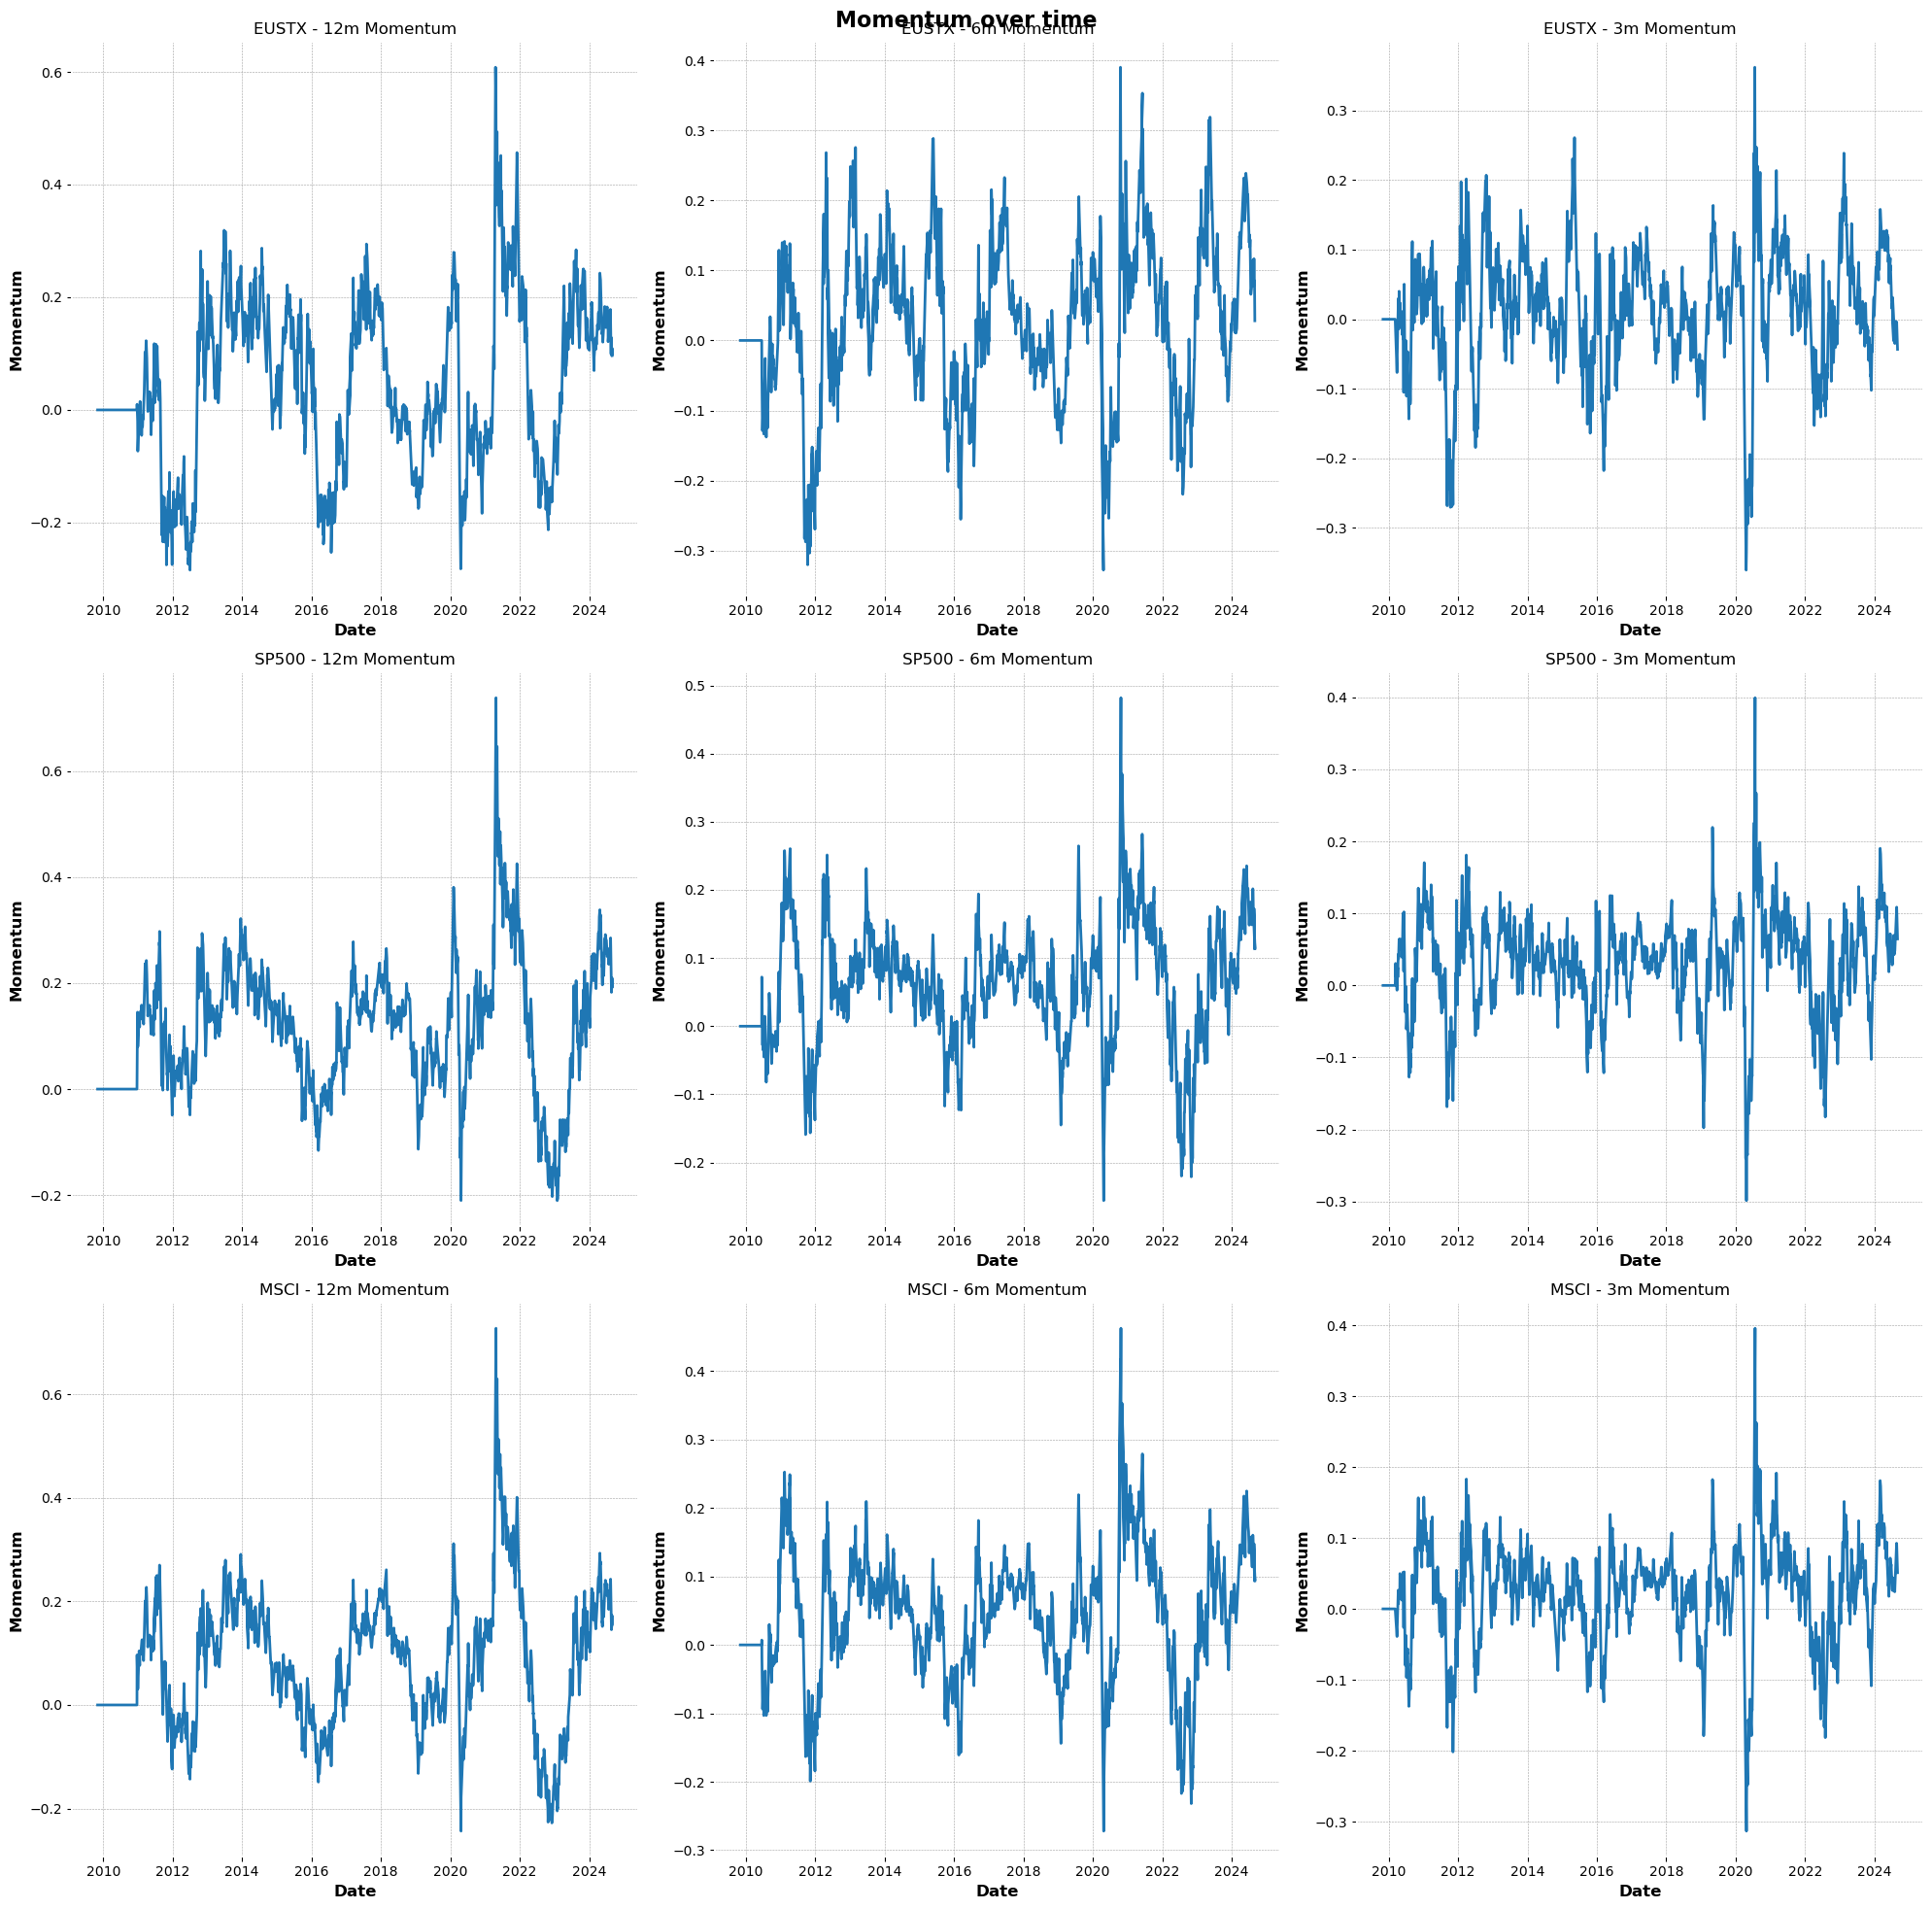

In [13]:
def calculate_momentum(data, column, lookback, skip=21):
    return data[column].pct_change(lookback).shift(skip)

def add_momentum_factors(data):
    datasets = ['eustx', 'sp500', 'msci']
    lookbacks = {
        '12m': 252,  # Approximately 252 trading days in a year
        '6m': 126,   # Approximately 126 trading days in 6 months
        '3m': 63     # Approximately 63 trading days in 3 months
    }
    
    for dataset in datasets:
        close_column = f'close_{dataset}'
        for period, lookback in lookbacks.items():
            momentum_column = f'momentum_{period}_{dataset}'
            data[momentum_column] = calculate_momentum(data, close_column, lookback)
            data[momentum_column] = data[momentum_column].fillna(0)
    
    return data

# Apply the function to add momentum factors
data = add_momentum_factors(data)

# Print the first few rows of the dataframe to verify
print(data[['Date'] + [col for col in data.columns if 'momentum' in col]].head(10))

# Print summary statistics of the Momentum columns
print("\nMomentum Summary Statistics:")
for col in data.columns:
    if 'momentum' in col:
        print(f"\n{col}:")
        print(data[col].describe())

# Plot momentum over time for each dataset and period
fig, axs = plt.subplots(3, 3, figsize=(20, 20))
fig.suptitle('Momentum over time', fontsize=16)

for i, dataset in enumerate(['eustx', 'sp500', 'msci']):
    for j, period in enumerate(['12m', '6m', '3m']):
        col = f'momentum_{period}_{dataset}'
        axs[i, j].plot(data['Date'], data[col])
        axs[i, j].set_title(f'{dataset.upper()} - {period} Momentum')
        axs[i, j].set_xlabel('Date')
        axs[i, j].set_ylabel('Momentum')

plt.tight_layout()
plt.show()

In [14]:
column_names = list(data)
column_names

['Date',
 'open_eustx',
 'high_eustx',
 'low_eustx',
 'close_eustx',
 'Mkt-RF',
 'SMB',
 'HML',
 'RMW',
 'CMA',
 'RF',
 'open_sp500',
 'high_sp500',
 'low_sp500',
 'close_sp500',
 'open_msci',
 'high_msci',
 'low_msci',
 'close_msci',
 'momentum_12m_eustx',
 'momentum_6m_eustx',
 'momentum_3m_eustx',
 'momentum_12m_sp500',
 'momentum_6m_sp500',
 'momentum_3m_sp500',
 'momentum_12m_msci',
 'momentum_6m_msci',
 'momentum_3m_msci']

### 2. Implement the Fama-French 5-Factor Model and Visualize Correlation with Heatmap


Processing EUSTX:
Columns in the dataframe: ['Date', 'open_eustx', 'high_eustx', 'low_eustx', 'close_eustx', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF', 'open_sp500', 'high_sp500', 'low_sp500', 'close_sp500', 'open_msci', 'high_msci', 'low_msci', 'close_msci', 'momentum_12m_eustx', 'momentum_6m_eustx', 'momentum_3m_eustx', 'momentum_12m_sp500', 'momentum_6m_sp500', 'momentum_3m_sp500', 'momentum_12m_msci', 'momentum_6m_msci', 'momentum_3m_msci']
Rows with NaN values removed: 1
Remaining observations: 3663

Regression results for EUSTX - Fama-French 5-factor model with Momentum:
                             OLS Regression Results                            
Dep. Variable:     Excess_Return_eustx   R-squared:                       0.399
Model:                             OLS   Adj. R-squared:                  0.398
Method:                  Least Squares   F-statistic:                     303.2
Date:                 Tue, 05 Nov 2024   Prob (F-statistic):               0.00
Time:         

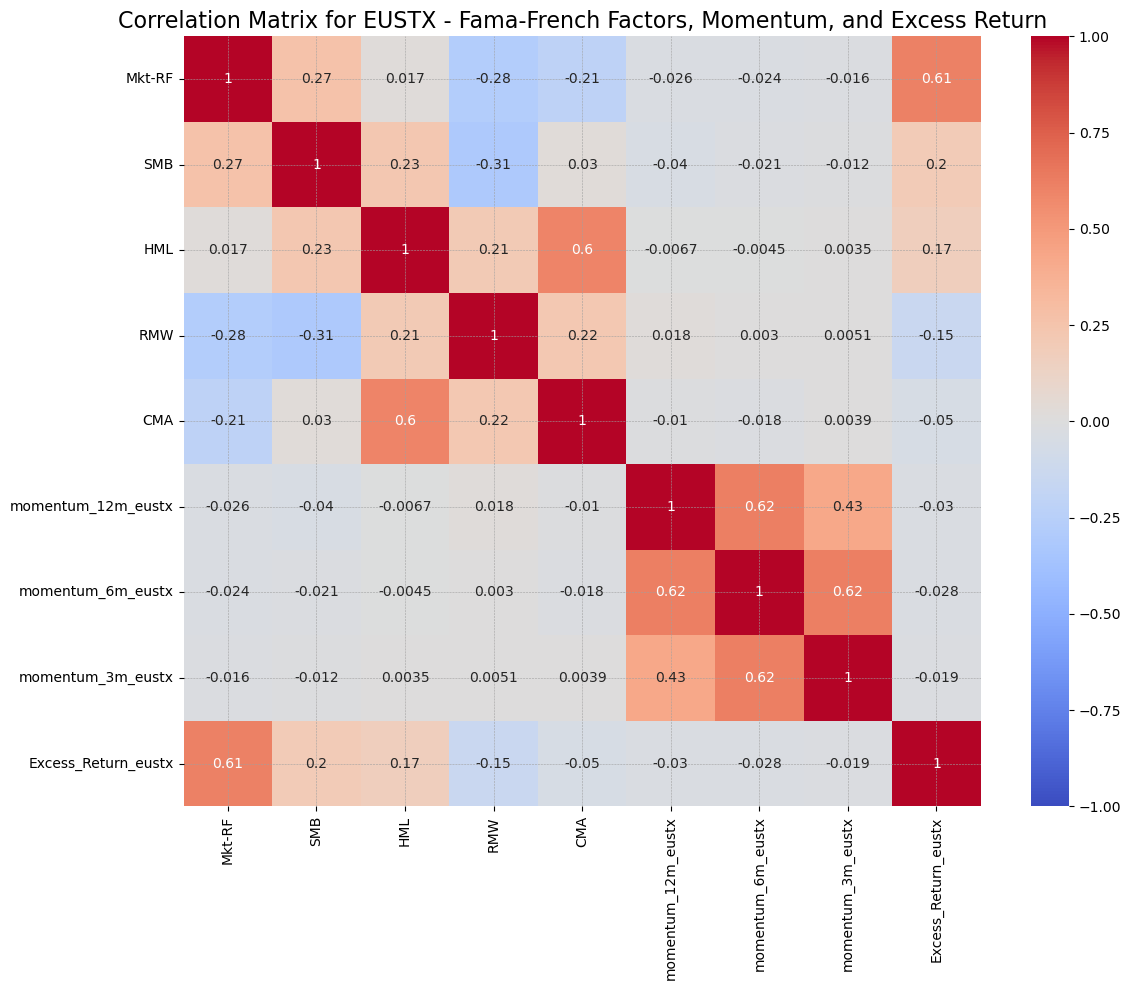


Correlation Matrix:
                       Mkt-RF       SMB       HML       RMW       CMA  \
Mkt-RF               1.000000  0.265180  0.017095 -0.280398 -0.213801   
SMB                  0.265180  1.000000  0.232994 -0.311147  0.029865   
HML                  0.017095  0.232994  1.000000  0.206483  0.596122   
RMW                 -0.280398 -0.311147  0.206483  1.000000  0.221061   
CMA                 -0.213801  0.029865  0.596122  0.221061  1.000000   
momentum_12m_eustx  -0.026320 -0.040143 -0.006655  0.018462 -0.010356   
momentum_6m_eustx   -0.023520 -0.021165 -0.004535  0.002959 -0.017594   
momentum_3m_eustx   -0.016254 -0.012054  0.003514  0.005091  0.003901   
Excess_Return_eustx  0.610697  0.198516  0.169505 -0.147406 -0.049894   

                     momentum_12m_eustx  momentum_6m_eustx  momentum_3m_eustx  \
Mkt-RF                        -0.026320          -0.023520          -0.016254   
SMB                           -0.040143          -0.021165          -0.012054   
HML  

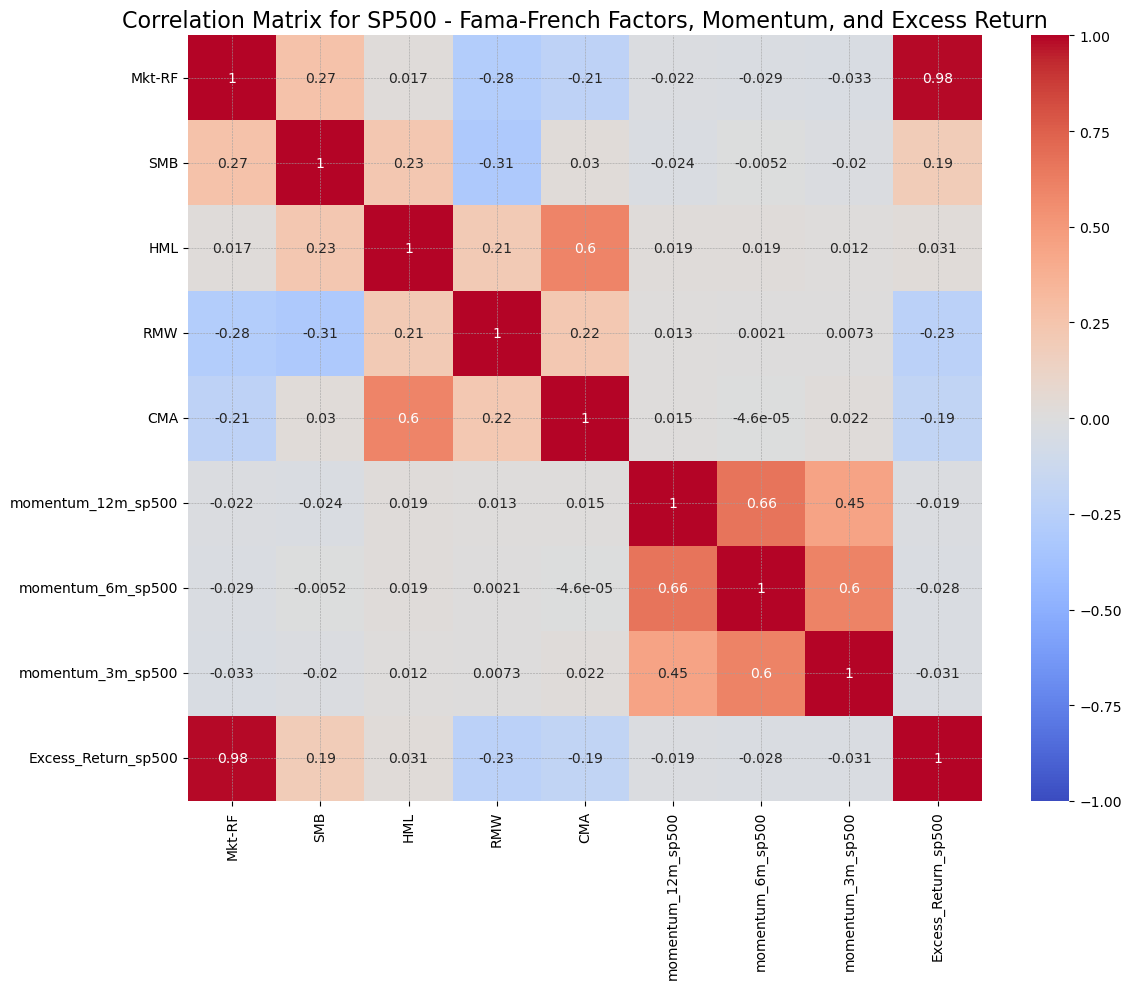


Correlation Matrix:
                       Mkt-RF       SMB       HML       RMW       CMA  \
Mkt-RF               1.000000  0.265180  0.017095 -0.280398 -0.213801   
SMB                  0.265180  1.000000  0.232994 -0.311147  0.029865   
HML                  0.017095  0.232994  1.000000  0.206483  0.596122   
RMW                 -0.280398 -0.311147  0.206483  1.000000  0.221061   
CMA                 -0.213801  0.029865  0.596122  0.221061  1.000000   
momentum_12m_sp500  -0.021771 -0.023613  0.018836  0.012544  0.015380   
momentum_6m_sp500   -0.029012 -0.005165  0.018683  0.002078 -0.000046   
momentum_3m_sp500   -0.033180 -0.019654  0.011620  0.007318  0.022452   
Excess_Return_sp500  0.984719  0.193506  0.030723 -0.229700 -0.192439   

                     momentum_12m_sp500  momentum_6m_sp500  momentum_3m_sp500  \
Mkt-RF                        -0.021771          -0.029012          -0.033180   
SMB                           -0.023613          -0.005165          -0.019654   
HML  

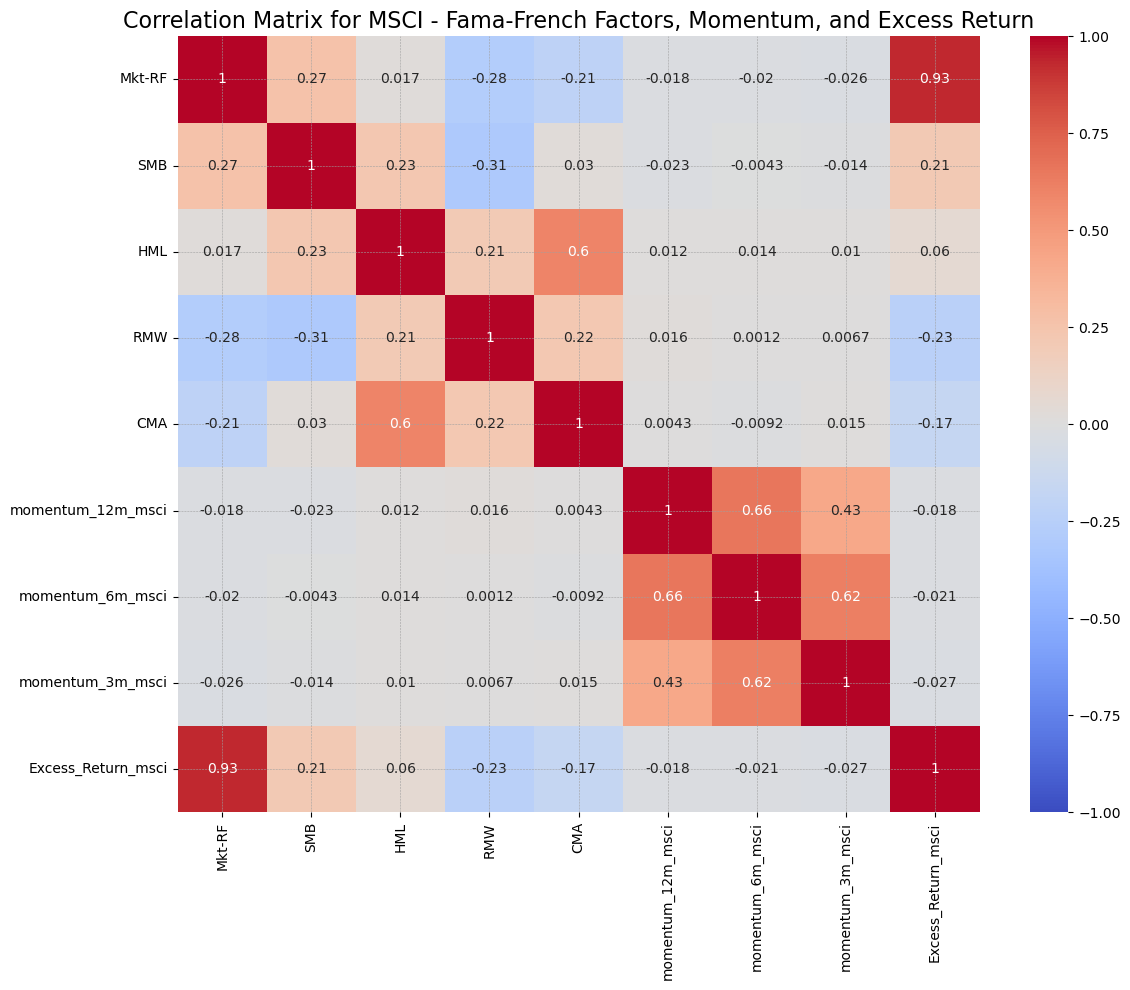


Correlation Matrix:
                      Mkt-RF       SMB       HML       RMW       CMA  \
Mkt-RF              1.000000  0.265180  0.017095 -0.280398 -0.213801   
SMB                 0.265180  1.000000  0.232994 -0.311147  0.029865   
HML                 0.017095  0.232994  1.000000  0.206483  0.596122   
RMW                -0.280398 -0.311147  0.206483  1.000000  0.221061   
CMA                -0.213801  0.029865  0.596122  0.221061  1.000000   
momentum_12m_msci  -0.017788 -0.022635  0.012472  0.016084  0.004336   
momentum_6m_msci   -0.019800 -0.004289  0.014147  0.001196 -0.009186   
momentum_3m_msci   -0.025655 -0.014136  0.010016  0.006733  0.014686   
Excess_Return_msci  0.929948  0.212971  0.059843 -0.234898 -0.170275   

                    momentum_12m_msci  momentum_6m_msci  momentum_3m_msci  \
Mkt-RF                      -0.017788         -0.019800         -0.025655   
SMB                         -0.022635         -0.004289         -0.014136   
HML                        

In [15]:
def compute_excess_return_run_regression_and_create_heatmap(data, fund):
    try:
        # Create a copy of the data to avoid modifying the original dataframe
        df = data.copy()
        
        print(f"\nProcessing {fund.upper()}:")
        print(f"Columns in the dataframe: {df.columns.tolist()}")
        
        # Check if 'Date' column exists
        if 'Date' not in df.columns:
            print("'Date' column is missing. Using the index as the date.")
            df['Date'] = df.index
        
        # Ensure Date is in datetime format and set as index
        df['Date'] = pd.to_datetime(df['Date'])
        df.set_index('Date', inplace=True)

        # Calculate daily returns
        df[f'Daily_Return_{fund}'] = df[f'close_{fund}'].pct_change()

        # Calculate excess returns: fund returns - Risk-free rate
        df[f'Excess_Return_{fund}'] = df[f'Daily_Return_{fund}'] - df['RF'] / 100  # Assuming RF is in percentage

        # Prepare factors for regression and correlation
        factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 
                   f'momentum_12m_{fund}', f'momentum_6m_{fund}', f'momentum_3m_{fund}',
                   f'Excess_Return_{fund}']

        # Check for NaN values in relevant columns
        nan_count_before = df[factors].isnull().sum().sum()
        df = df.dropna(subset=factors)
        nan_count_after = df[factors].isnull().sum().sum()

        print(f"Rows with NaN values removed: {nan_count_before - nan_count_after}")
        print(f"Remaining observations: {len(df)}")

        # Regression analysis
        X = df[factors[:-1]]  # All factors except Excess_Return
        y = df[f'Excess_Return_{fund}']
        
        X = sm.add_constant(X)  # Add constant term

        # Run OLS regression
        model = sm.OLS(y, X).fit()
        
        print(f"\nRegression results for {fund.upper()} - Fama-French 5-factor model with Momentum:")
        print(model.summary())

        # Create correlation heatmap
        corr_matrix = df[factors].corr()
        
        plt.figure(figsize=(12, 10))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
        plt.title(f'Correlation Matrix for {fund.upper()} - Fama-French Factors, Momentum, and Excess Return', fontsize=16)
        plt.tight_layout()
        plt.show()

        print("\nCorrelation Matrix:")
        print(corr_matrix)

        print(f"\nHighly correlated factors for {fund.upper()} (|correlation| > 0.5):")
        for i in range(len(factors)):
            for j in range(i+1, len(factors)):
                if abs(corr_matrix.iloc[i, j]) > 0.5:
                    print(f"{factors[i]} and {factors[j]}: {corr_matrix.iloc[i, j]:.2f}")

    except Exception as e:
        print(f"Error processing data for {fund}: {str(e)}")
        print(f"Error type: {type(e).__name__}")
        print(f"Error details: {e.args}")
        print("DataFrame info:")
        print(df.info())

# Run the computation, regression, and create heatmap for each fund
for fund in ['eustx', 'sp500', 'msci']:
    compute_excess_return_run_regression_and_create_heatmap(data, fund)

### 3. Data Analysis

##### 3.1 Performance analysis

Risk-adjusted returns

In [16]:
def calculate_performance_metrics(data, fund):
    try:
        # Create a copy of the data to avoid modifying the original dataframe
        df = data.copy()

        # Ensure Date is in datetime format and set as index
        df['Date'] = pd.to_datetime(df['Date'])
        df.set_index('Date', inplace=True)

        # Calculate daily returns for the fund
        df[f'Daily_Return_{fund}'] = df[f'close_{fund}'].pct_change()

        # Calculate excess returns: fund returns - Risk-free rate
        df[f'Excess_Return_{fund}'] = df[f'Daily_Return_{fund}'] - df['RF'] / 100  # Assuming RF is in percentage

        # Calculate average daily return and standard deviation of daily returns
        avg_daily_return = df[f'Daily_Return_{fund}'].mean()
        std_daily_return = df[f'Daily_Return_{fund}'].std()
        
        # Calculate annualized metrics
        risk_free_rate = df['RF'].mean() / 100  # Convert to decimal
        annualized_return = (1 + avg_daily_return) ** 252 - 1
        annualized_volatility = std_daily_return * np.sqrt(252)
        
        # Cumulative return
        cumulative_return = (1 + df[f'Daily_Return_{fund}']).cumprod() - 1
        
        # 1. Annualized Return
        print(f"\nPerformance Metrics for {fund.upper()}:")
        print(f"1. Annualized Return: {annualized_return:.4f}")
        
        # 2. Cumulative Return
        print(f"2. Cumulative Return: {cumulative_return.iloc[-1]:.4f}")

        # 3. Annualized Volatility
        print(f"3. Annualized Volatility: {annualized_volatility:.4f}")

        # 4. Sharpe Ratio
        sharpe_ratio = (avg_daily_return - risk_free_rate) / std_daily_return if std_daily_return != 0 else np.nan
        print(f"4. Sharpe Ratio: {sharpe_ratio:.4f}")
        
        # 5. Sortino Ratio (using downside deviation)
        downside_returns = df[f'Daily_Return_{fund}'][df[f'Daily_Return_{fund}'] < 0]
        downside_deviation = np.sqrt((downside_returns**2).mean())
        sortino_ratio = (avg_daily_return - risk_free_rate) / downside_deviation if downside_deviation != 0 else np.nan
        print(f"5. Sortino Ratio: {sortino_ratio:.4f}")
        
        # 6. Treynor Ratio (assuming market return is the average of Mkt-RF)
        market_return = df['Mkt-RF'].mean() / 100  # Convert to decimal
        treynor_ratio = (annualized_return - risk_free_rate) / market_return if market_return != 0 else np.nan
        print(f"6. Treynor Ratio: {treynor_ratio:.4f}")
        
        # 7. Alpha using CAPM: α = R_fund - [R_free + β * (R_market - R_free)]
        X = sm.add_constant(df['Mkt-RF'])  # Adding constant for regression
        model = sm.OLS(df[f'Daily_Return_{fund}'], X).fit()
        beta = model.params[1]  # Beta is the slope coefficient for Mkt-RF
        alpha = avg_daily_return - (risk_free_rate + beta * (market_return - risk_free_rate))
        print(f"7. Alpha: {alpha:.4f}")
        
        # 8. Information Ratio: Excess return relative to tracking error
        tracking_error = np.sqrt(((df[f'Excess_Return_{fund}'] - (df['Mkt-RF'])).dropna())**2).mean()
        information_ratio = (avg_daily_return - market_return) / tracking_error if tracking_error != 0 else np.nan
        print(f"8. Information Ratio: {information_ratio:.4f}")
        
        # 9. M2 Measure (Modigliani Measure)
        m2_measure = ((annualized_volatility / std_daily_return) * (annualized_return - risk_free_rate)) + risk_free_rate
        print(f"9. M2 Measure: {m2_measure:.4f}")

    except Exception as e:
        print(f"Error processing data for {fund}: {str(e)}")
        print(f"Error type: {type(e).__name__}")
        print(f"Error details: {e.args}")

# Run performance metrics calculation for each fund
for fund in ['eustx', 'sp500', 'msci']:
    calculate_performance_metrics(data, fund)


Performance Metrics for EUSTX:
1. Annualized Return: 0.0645
2. Cumulative Return: 0.8280
3. Annualized Volatility: 0.2046
4. Sharpe Ratio: 0.0160
5. Sortino Ratio: 0.0153
6. Treynor Ratio: 119.7118
7. Alpha: nan
8. Information Ratio: -0.0004
9. M2 Measure: 1.0230

Performance Metrics for SP500:
1. Annualized Return: 0.1402
2. Cumulative Return: 4.4030
3. Annualized Volatility: 0.1738
4. Sharpe Ratio: 0.0438
5. Sortino Ratio: 0.0413
6. Treynor Ratio: 260.4039
7. Alpha: nan
8. Information Ratio: -0.0000
9. M2 Measure: 2.2252

Performance Metrics for MSCI:
1. Annualized Return: 0.0989
2. Cumulative Return: 2.3161
3. Annualized Volatility: 0.1536
4. Sharpe Ratio: 0.0344
5. Sortino Ratio: 0.0321
6. Treynor Ratio: 183.6648
7. Alpha: nan
8. Information Ratio: -0.0002
9. M2 Measure: 1.5695


Factor-Adjusted Performance

In [17]:
# Compute Fama-French Alpha for each fund
def calculate_fama_french_alpha(data, fund):
    try:
        # Create a copy of the data to avoid modifying the original dataframe
        df = data.copy()

        # Ensure Date is in datetime format and set as index
        df['Date'] = pd.to_datetime(df['Date'])
        df.set_index('Date', inplace=True)

        # Calculate daily returns for the fund
        df[f'Daily_Return_{fund}'] = df[f'close_{fund}'].pct_change()

        # Calculate excess returns: fund returns - risk-free rate
        df[f'Excess_Return_{fund}'] = df[f'Daily_Return_{fund}'] - df['RF'] / 100  # Assuming RF is in percentage

        # Prepare factors for regression
        X = df[['Mkt-RF', 'SMB', 'HML']].dropna()  # Independent variables
        y = df[f'Excess_Return_{fund}'].dropna()   # Dependent variable

        # Align X and y to ensure they have the same index after dropping NaN values
        common_index = X.index.intersection(y.index)
        X = X.loc[common_index]
        y = y.loc[common_index]

        # Add constant term for regression
        X = sm.add_constant(X)

        # Run OLS regression
        model = sm.OLS(y, X).fit()

        # Extract alpha (intercept)
        alpha = model.params['const']
        
        print(f"\nFama-French Alpha for {fund.upper()}: {alpha:.4f}")

    except Exception as e:
        print(f"Error processing data for {fund}: {str(e)}")
        print(f"Error type: {type(e).__name__}")
        print(f"Error details: {e.args}")

# Run Fama-French Alpha calculation for each fund
for fund in ['eustx', 'sp500', 'msci']:
    calculate_fama_french_alpha(data, fund)


Fama-French Alpha for EUSTX: -0.0002

Fama-French Alpha for SP500: -0.0001

Fama-French Alpha for MSCI: -0.0001


##### 3.2 Robustness Check

Time-Varying Factor Exposures

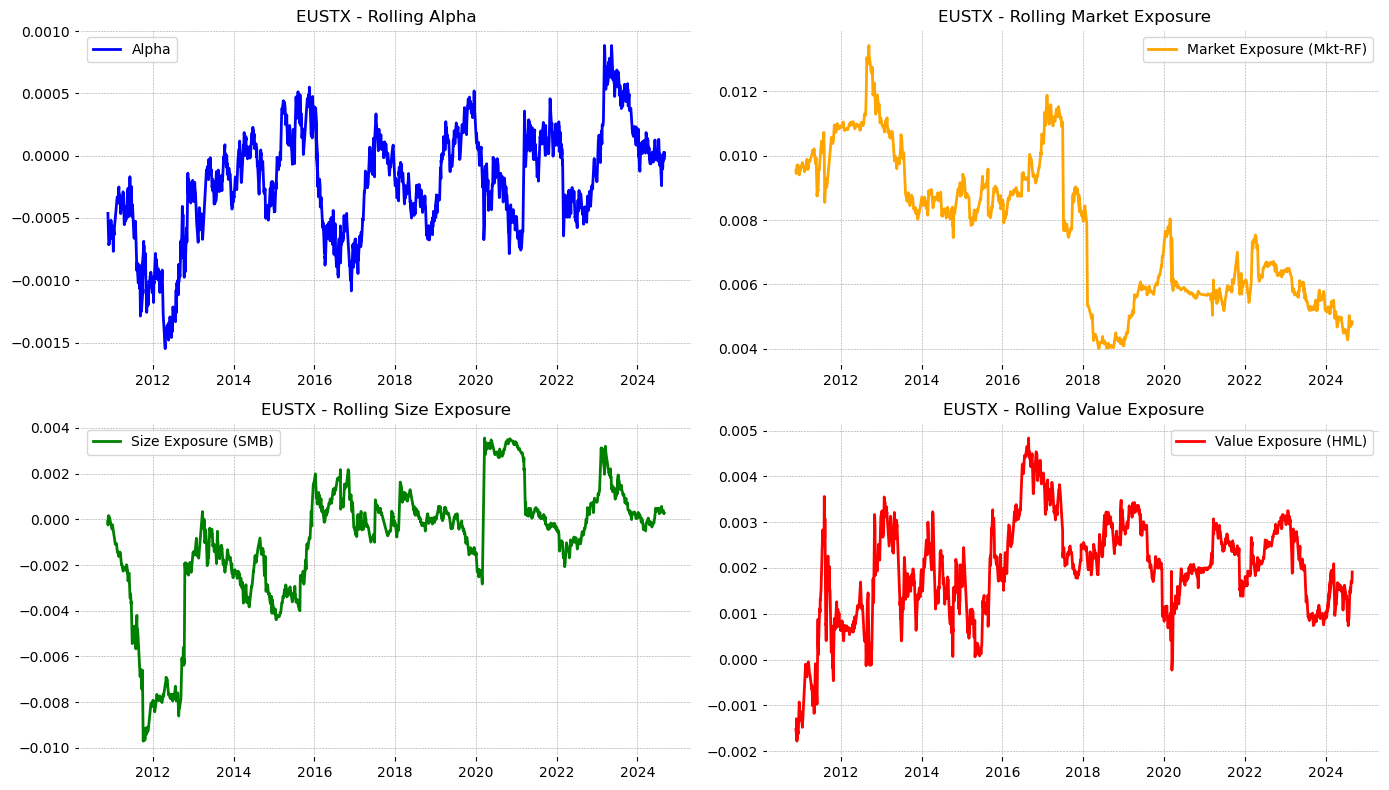

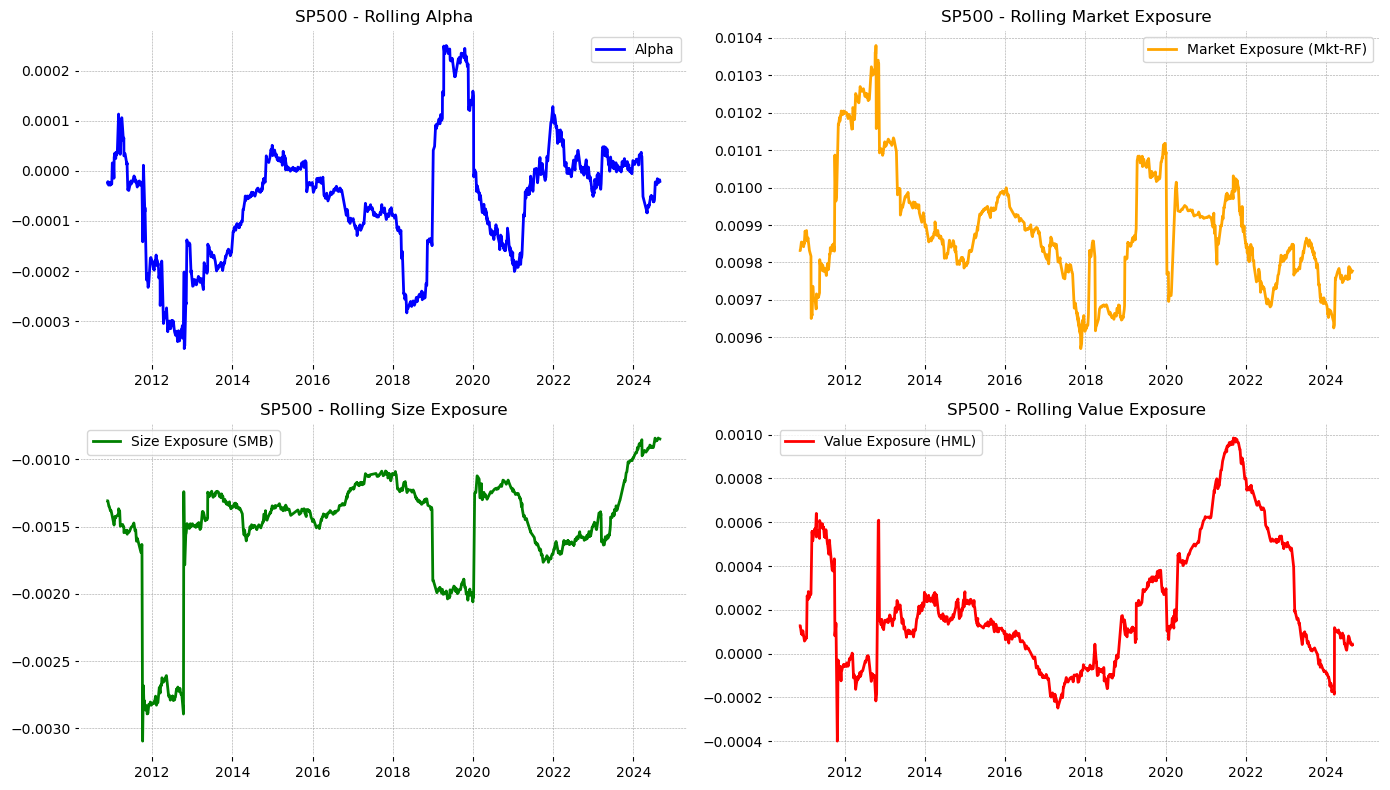

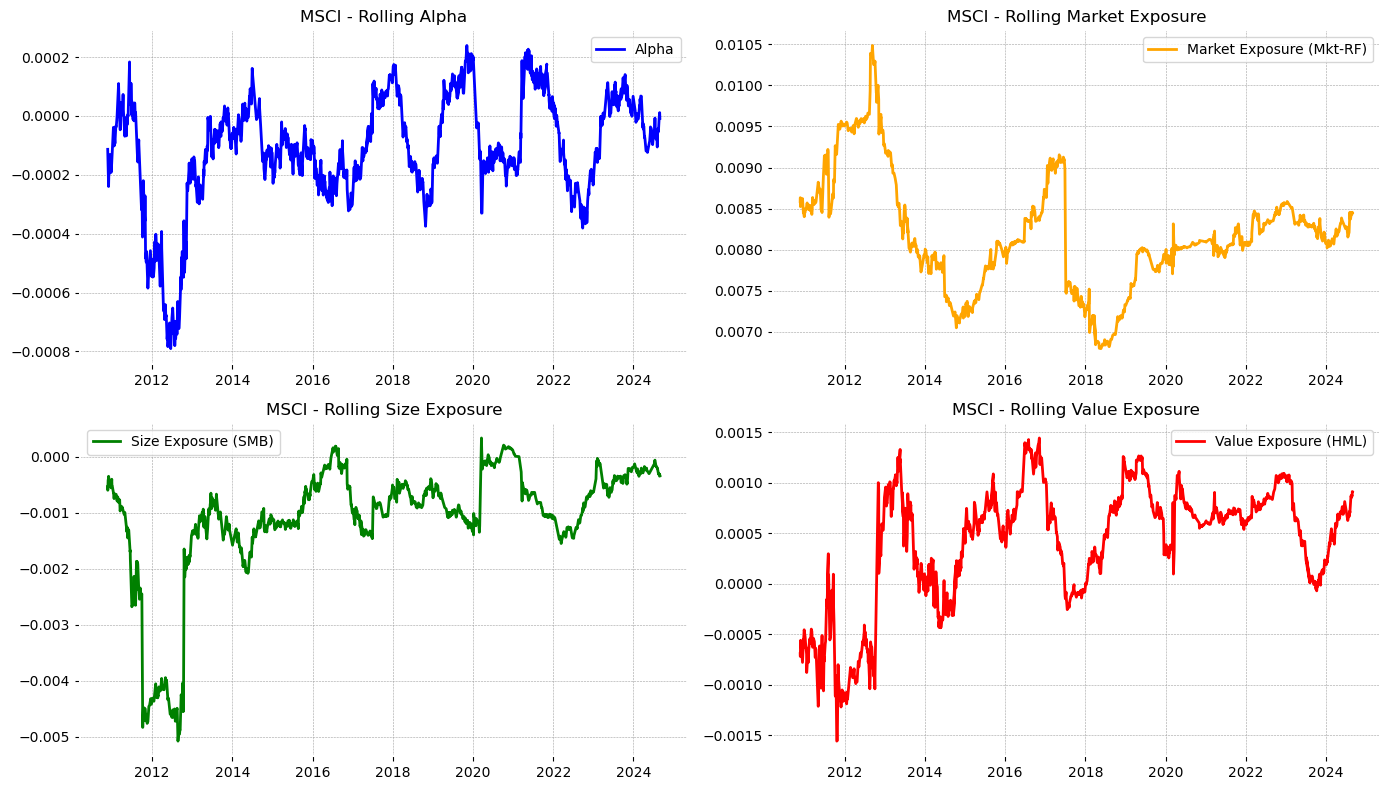

In [18]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

def rolling_regression(data, fund, window=252):
    try:
        # Create a copy of the data to avoid modifying the original dataframe
        df = data.copy()

        # Ensure Date is in datetime format and set as index
        df['Date'] = pd.to_datetime(df['Date'])
        df.set_index('Date', inplace=True)

        # Calculate daily returns for the fund
        df[f'Daily_Return_{fund}'] = df[f'close_{fund}'].pct_change()

        # Calculate excess returns: fund returns - risk-free rate
        df[f'Excess_Return_{fund}'] = df[f'Daily_Return_{fund}'] - df['RF'] / 100  # Assuming RF is in percentage

        # Prepare factors for regression
        factors = ['Mkt-RF', 'SMB', 'HML']
        
        # Store results in a DataFrame
        results = pd.DataFrame(index=df.index)

        # Perform rolling regression
        for start in range(len(df) - window):
            end = start + window
            rolling_window_data = df.iloc[start:end]

            # Prepare X and y for regression
            X = rolling_window_data[factors].dropna()
            y = rolling_window_data[f'Excess_Return_{fund}'].dropna()

            # Ensure X and y have matching indices after dropping NaN values
            common_index = X.index.intersection(y.index)
            X = X.loc[common_index]
            y = y.loc[common_index]

            if len(y) > 0:  # Check if there are enough data points for regression
                X_with_const = sm.add_constant(X)
                model = sm.OLS(y, X_with_const).fit()
                results.loc[rolling_window_data.index[-1], 'Alpha'] = model.params['const']
                results.loc[rolling_window_data.index[-1], 'Mkt-RF'] = model.params['Mkt-RF']
                results.loc[rolling_window_data.index[-1], 'SMB'] = model.params['SMB']
                results.loc[rolling_window_data.index[-1], 'HML'] = model.params['HML']

        # Plotting the results of the rolling regression analysis
        plt.figure(figsize=(14, 8))
        plt.subplot(2, 2, 1)
        plt.plot(results['Alpha'], label='Alpha', color='blue')
        plt.title(f'{fund.upper()} - Rolling Alpha')
        plt.legend()

        plt.subplot(2, 2, 2)
        plt.plot(results['Mkt-RF'], label='Market Exposure (Mkt-RF)', color='orange')
        plt.title(f'{fund.upper()} - Rolling Market Exposure')
        plt.legend()

        plt.subplot(2, 2, 3)
        plt.plot(results['SMB'], label='Size Exposure (SMB)', color='green')
        plt.title(f'{fund.upper()} - Rolling Size Exposure')
        plt.legend()

        plt.subplot(2, 2, 4)
        plt.plot(results['HML'], label='Value Exposure (HML)', color='red')
        plt.title(f'{fund.upper()} - Rolling Value Exposure')
        plt.legend()

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error processing data for {fund}: {str(e)}")
        print(f"Error type: {type(e).__name__}")
        print(f"Error details: {e.args}")

# Run rolling regression analysis for each fund with a specified window size (e.g., 252 trading days)
for fund in ['eustx', 'sp500', 'msci']:
    rolling_regression(data, fund, window=252)